In [20]:
import numpy as np
import subprocess
import shlex
from glob import glob

files = sorted(glob("../../tmp/output_*.npz"))

In [1]:
import numpy as np
import subprocess, shlex

data = np.load('../../tmp/output_000000.npz')
frames = data['frames']           # shape (N, H, W, 4) BGRA
n, H, W, C = frames.shape
assert C == 4

# convert to true RGB
rgb = frames[..., :3][..., ::-1]  # (N, H, W, 3)

cmd = (
    f"ffmpeg -y "
    f"-f rawvideo -vcodec rawvideo "
    f"-pix_fmt rgb24 -s {W}x{H} -r 10 -i - "
    f"-an -c:v libx264 -pix_fmt yuv420p output.mp4"
)
proc = subprocess.Popen(shlex.split(cmd), stdin=subprocess.PIPE)
proc.stdin.write(rgb.tobytes())
proc.stdin.close()
ret = proc.wait()
if ret: raise RuntimeError("ffmpeg failed")
print("✅ output.mp4")


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

✅ output.mp4


[out#0/mp4 @ 0x14ce2f920] video:3193KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 0.073026%
frame=  128 fps= 44 q=-1.0 Lsize=    3196KiB time=00:00:12.60 bitrate=2077.8kbits/s speed=4.38x    
[libx264 @ 0x14ce30ad0] frame I:5     Avg QP:10.83  size:353983
[libx264 @ 0x14ce30ad0] frame P:39    Avg QP:19.30  size: 24036
[libx264 @ 0x14ce30ad0] frame B:84    Avg QP:17.32  size:  6691
[libx264 @ 0x14ce30ad0] consecutive B-frames: 10.2%  4.7%  7.0% 78.1%
[libx264 @ 0x14ce30ad0] mb I  I16..4: 51.7% 27.0% 21.3%
[libx264 @ 0x14ce30ad0] mb P  I16..4:  0.7%  1.6%  1.8%  P16..4:  1.4%  0.2%  0.1%  0.0%  0.0%    skip:94.1%
[libx264 @ 0x14ce30ad0] mb B  I16..4:  0.1%  0.1%  0.5%  B16..8:  2.3%  0.1%  0.0%  direct: 0.0%  skip:96.7%  L0:51.0% L1:48.4% BI: 0.6%
[libx264 @ 0x14ce30ad0] 8x8 transform intra:28.6% inter:26.5%
[libx264 @ 0x14ce30ad0] coded y,uvDC,uvAC intra: 22.1% 27.7% 25.6% inter: 0.2% 0.2% 0.1%
[libx264 @ 0x14ce30ad0] i16 v,h,dc,p: 82% 17%  1%  0%


In [ ]:
ffmpeg -f avfoundation -framerate 30 \
    -use_wallclock_as_timestamps 1 -i "1:none" \
    -c:v libx264 -g 15 -c:a aac -preset veryfast -crf 17 \
    -copyts -muxdelay 0 \
    -segment_time 10 -f segment \
    -r 30 tmp/video_%03d.mp4

In [21]:
def load_npz(fname):
    data = np.load(fname)
    frames = data['frames']
    return frames

In [22]:
cmd = (
    "ffmpeg -y "
    "-f rawvideo -vcodec rawvideo "
    "-pix_fmt bgra -s {w}x{h} -r 10 -i - "
    "-an -c:v libx264 -pix_fmt yuv420p output.mp4"
)

In [23]:
from concurrent.futures import ThreadPoolExecutor
pool = ThreadPoolExecutor(max_workers=1)

In [24]:
current_idx = 0
current = load_npz(files[current_idx])
H, W = current.shape[1:3]

In [ ]:
proc = subprocess.Popen(
    shlex.split(cmd.format(w=W, h=H)),
    stdin=subprocess.PIPE
)

future = None
if current_idx + 1 < len(files):
    future = pool.submit(load_npz, files[current_idx+1])

while True:
    # 5a) send all frames from current buffer
    proc.stdin.write(current.tobytes())

    # 5b) move on
    current_idx += 1
    if future is None:
        break   # no more files
    # get the preloaded data
    next_buf = future.result()
    # kick off preload of the next one
    future = None
    if current_idx+1 < len(files):
        future = pool.submit(load_npz, files[current_idx+1])
    # swap in
    current = next_buf

proc.stdin.close()
ret = proc.wait()
if ret != 0:
    raise RuntimeError(f"ffmpeg exited {ret}")
print("✅ output.mp4 created!")

ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

BadZipFile: File is not a zip file

In [3]:
import av

In [55]:
# VIDEO_PATH = '../../../tmp/2025-06-10_231949_ABTR8/screen_capture_000000.mp4'
VIDEO_PATH = "/Users/jonathan/Documents/programming/induction/induction-labs/repos/actioncollector/tmp/action_capture/jonathan/2025-06-14_140546_PWLAD/screen_capture_000000.mp4"
container = av.open(VIDEO_PATH)
video_stream = container.streams.video[0]

In [56]:
import json
ACTIONS_PATH = [
    f"/Users/jonathan/Documents/programming/induction/induction-labs/repos/actioncollector/tmp/action_capture/jonathan/2025-06-14_140546_PWLAD/action_capture_000000.jsonl"
    # f'../../../tmp/2025-06-12_111012_Y7FM5/action_capture_{i:06d}.jsonl'
    # for i in range(0, 2)
]

# Load actions (one JSON record per line)
actions = []
for path in ACTIONS_PATH:
    with open(path, 'r') as f:
        for line in f:
            rec = json.loads(line)
            act = rec['action']
            if act["action"] == "mouse_move":
                # timestamp assumed in milliseconds
                actions.append({'timestamp': rec['timestamp'], 'x': act['x']*2, 'y': act['y']*2})

In [57]:
actions.sort(key=lambda a: a['timestamp'])
timestamps = [a['timestamp'] for a in actions]

In [27]:
print(actions[-1])

{'timestamp': 1749919952.665941, 'x': 1396, 'y': 1802}


In [58]:
previous_time = None
for i, frame in enumerate(container.decode(video=0)):
    # frame.pts is the integer PTS in stream time_base units
    pts = frame.pts
    # stream.time_base is a Fraction, so pts * time_base gives seconds
    seconds = float(pts * video_stream.time_base)
    # seconds is a utc timestamp in seconds
    # actual_frame_time = datetime.datetime.fromtimestamp(seconds)
    if previous_time:
        print(f"Frame {i} at {seconds:.3f} seconds")
        # print delta
        print(f"Delta: {seconds - previous_time:.3f} seconds")
    previous_time = seconds

    if i > 50:
        break

Frame 1 at 1749924346.702 seconds
Delta: 0.053 seconds
Frame 2 at 1749924346.729 seconds
Delta: 0.027 seconds
Frame 3 at 1749924346.754 seconds
Delta: 0.025 seconds
Frame 4 at 1749924346.793 seconds
Delta: 0.039 seconds
Frame 5 at 1749924346.829 seconds
Delta: 0.036 seconds
Frame 6 at 1749924346.854 seconds
Delta: 0.025 seconds
Frame 7 at 1749924346.892 seconds
Delta: 0.038 seconds
Frame 8 at 1749924346.930 seconds
Delta: 0.037 seconds
Frame 9 at 1749924346.954 seconds
Delta: 0.025 seconds
Frame 10 at 1749924346.992 seconds
Delta: 0.037 seconds
Frame 11 at 1749924347.027 seconds
Delta: 0.035 seconds
Frame 12 at 1749924347.060 seconds
Delta: 0.033 seconds
Frame 13 at 1749924347.095 seconds
Delta: 0.035 seconds
Frame 14 at 1749924347.120 seconds
Delta: 0.025 seconds
Frame 15 at 1749924347.157 seconds
Delta: 0.038 seconds
Frame 16 at 1749924347.195 seconds
Delta: 0.038 seconds
Frame 17 at 1749924347.221 seconds
Delta: 0.025 seconds
Frame 18 at 1749924347.258 seconds
Delta: 0.037 seconds
F

In [ ]:
import datetime
from PIL import ImageDraw
import bisect
from IPython.display import display, clear_output

previous_time = None
for i, frame in enumerate(container.decode(video=0)):
    # frame.pts is the integer PTS in stream time_base units
    pts = frame.pts
    # stream.time_base is a Fraction, so pts * time_base gives seconds
    seconds = float(pts * video_stream.time_base)
    # seconds is a utc timestamp in seconds
    actual_frame_time = datetime.datetime.fromtimestamp(seconds)

    clear_output(wait=True)

    print(f"Frame #{i}: PTS={pts:7d}  ({seconds:.3f} s); {actual_frame_time.isoformat()}")
    if previous_time is not None:
        delta = seconds - previous_time
        print(f"  Delta: {delta:.3f} s")
    else:
        print("  First frame")

    prev_idx = bisect.bisect_left(timestamps, seconds * 1e3)
    next_idx = bisect.bisect_right(timestamps, seconds * 1e3)
    idx = bisect.bisect_left(timestamps, seconds * 1e3) + 1

    low = actions[idx-1] if idx > 0 else None
    high = actions[idx] if idx < len(timestamps) else None
    if low is None and high is not None:
        low = high
    if high is None and low is not None:
        high = low

    # if idx == 0:
    #     prev_idx, next_idx = 0, 1 if len(actions) > 1 else 0
    # elif idx >= len(actions):
    #     prev_idx, next_idx = len(actions) - 2 if len(actions) > 1 else 0, len(actions) - 1
    # else:
    #     prev_idx, next_idx = idx, idx + 1

    action_prev = low
    action_prev_time = action_prev['timestamp']/1000.0
    action_next = high
    action_next_time = action_next['timestamp']/1000.0
    print(f"prev action time: {action_prev_time:.3f}s, video time: {seconds:.3f}s, diff: {action_prev_time - seconds:.3f}s")
    print(f"next action time: {action_next_time:.3f}s, video time: {seconds:.3f}s, diff: {action_next_time - seconds:.3f}s")

    previous_time = seconds

    # lerp by the time difference
    mid_x = action_prev['x'] + (action_next['x'] - action_prev['x']) * (seconds - action_prev_time) / (action_next_time - action_prev_time)
    mid_y = action_prev['y'] + (action_next['y'] - action_prev['y']) * (seconds - action_prev_time) / (action_next_time - action_prev_time)
    # niave guess
    # mid_x = (action_prev['x'] + action_next['x']) / 2
    # mid_y = (action_prev['y'] + action_next['y']) / 2

    img = frame.to_image().convert('RGB')
    draw = ImageDraw.Draw(img)
    r = 20  # radius in pixels
    print(img.size, mid_x, mid_y)
    draw.ellipse((mid_x - r, mid_y - r, mid_x + r, mid_y + r), outline='red', width=3)

    # Display the annotated frame
    display(img)

    # if i >= 100:
    #     input("Next frame?")
    # if i >= 10:
    #     break
    

In [12]:
actions

[{'timestamp': 1749741013.788639, 'x': 1066, 'y': 1216},
 {'timestamp': 1749741013.789163, 'x': 1068, 'y': 1212},
 {'timestamp': 1749741013.789491, 'x': 1072, 'y': 1208},
 {'timestamp': 1749741013.79767, 'x': 1082, 'y': 1194},
 {'timestamp': 1749741013.815687, 'x': 1092, 'y': 1182},
 {'timestamp': 1749741013.8158832, 'x': 1096, 'y': 1174},
 {'timestamp': 1749741013.821346, 'x': 1104, 'y': 1160},
 {'timestamp': 1749741013.829086, 'x': 1112, 'y': 1148},
 {'timestamp': 1749741013.837001, 'x': 1120, 'y': 1134},
 {'timestamp': 1749741013.844897, 'x': 1128, 'y': 1124},
 {'timestamp': 1749741013.8527203, 'x': 1136, 'y': 1112},
 {'timestamp': 1749741013.860732, 'x': 1138, 'y': 1110},
 {'timestamp': 1749741013.86856, 'x': 1144, 'y': 1104},
 {'timestamp': 1749741013.876401, 'x': 1148, 'y': 1102},
 {'timestamp': 1749741013.8843422, 'x': 1152, 'y': 1100},
 {'timestamp': 1749741014.342973, 'x': 1154, 'y': 1100},
 {'timestamp': 1749741014.350891, 'x': 1160, 'y': 1098},
 {'timestamp': 1749741014.3585

In [29]:
import datetime
from PIL import ImageDraw
import bisect
from IPython.display import display, clear_output

In [54]:
float(512 * video_stream.time_base * 100)

0.0512

In [60]:
output = av.open('output_realtime_100.mp4', mode='w')
out_stream = output.add_stream('libx264', rate=video_stream.average_rate)
out_stream.width = video_stream.width
out_stream.height = video_stream.height
out_stream.pix_fmt = 'yuv420p'

previous_time = None

container.seek(0, any_frame=True)  # Reset to the start of the video
for i, frame in enumerate(container.decode(video=0)):
    # Compute frame time
    pts = frame.pts
    one_frame_time = float(512 * video_stream.time_base)
    seconds = float(pts * video_stream.time_base) - one_frame_time * 100

    # Find surrounding actions
    idx = bisect.bisect_left(timestamps, seconds)
    low_idx = max(idx - 1, 0)
    high_idx = min(idx, len(actions) - 1)

    action_prev = actions[low_idx]
    action_next = actions[high_idx]
    action_prev_time = action_prev['timestamp']
    action_next_time = action_next['timestamp']

    print(f"Frame #{i}: PTS={pts:7d}  ({seconds:.3f} s); "
          f"Prev action at {action_prev_time:.3f}s, Next action at {action_next_time:.3f}s")

    # Linear interpolation (avoid division by zero)
    if action_next_time != action_prev_time:
        t = (seconds - action_prev_time) / (action_next_time - action_prev_time)
    else:
        t = 0.0
    mid_x = action_prev['x'] + (action_next['x'] - action_prev['x']) * t
    mid_y = action_prev['y'] + (action_next['y'] - action_prev['y']) * t

    # Draw overlay on PIL image
    img = frame.to_image().convert('RGB')
    draw = ImageDraw.Draw(img)
    r = 20
    draw.ellipse((mid_x - r, mid_y - r, mid_x + r, mid_y + r), outline='red', width=3)

    # Convert back to VideoFrame
    annotated = av.VideoFrame.from_image(img)

    # Encode and mux
    for packet in out_stream.encode(annotated):
        output.mux(packet)

# Flush encoder
for packet in out_stream.encode():
    output.mux(packet)

output.close()
print("Finished writing output.mp4")


Frame #0: PTS=1749924346649000  (1749924346.598 s); Prev action at 1749924346.594s, Next action at 1749924346.602s
Frame #1: PTS=1749924346701879  (1749924346.651 s); Prev action at 1749924346.602s, Next action at 1749924346.934s
Frame #2: PTS=1749924346728634  (1749924346.677 s); Prev action at 1749924346.602s, Next action at 1749924346.934s
Frame #3: PTS=1749924346753978  (1749924346.703 s); Prev action at 1749924346.602s, Next action at 1749924346.934s
Frame #4: PTS=1749924346792879  (1749924346.742 s); Prev action at 1749924346.602s, Next action at 1749924346.934s
Frame #5: PTS=1749924346829108  (1749924346.778 s); Prev action at 1749924346.602s, Next action at 1749924346.934s
Frame #6: PTS=1749924346854036  (1749924346.803 s); Prev action at 1749924346.602s, Next action at 1749924346.934s
Frame #7: PTS=1749924346892250  (1749924346.841 s); Prev action at 1749924346.602s, Next action at 1749924346.934s
Frame #8: PTS=1749924346929555  (1749924346.878 s); Prev action at 1749924346.60

In [14]:
actions

[{'timestamp': 1749741013.788639, 'x': 1066, 'y': 1216},
 {'timestamp': 1749741013.789163, 'x': 1068, 'y': 1212},
 {'timestamp': 1749741013.789491, 'x': 1072, 'y': 1208},
 {'timestamp': 1749741013.79767, 'x': 1082, 'y': 1194},
 {'timestamp': 1749741013.815687, 'x': 1092, 'y': 1182},
 {'timestamp': 1749741013.8158832, 'x': 1096, 'y': 1174},
 {'timestamp': 1749741013.821346, 'x': 1104, 'y': 1160},
 {'timestamp': 1749741013.829086, 'x': 1112, 'y': 1148},
 {'timestamp': 1749741013.837001, 'x': 1120, 'y': 1134},
 {'timestamp': 1749741013.844897, 'x': 1128, 'y': 1124},
 {'timestamp': 1749741013.8527203, 'x': 1136, 'y': 1112},
 {'timestamp': 1749741013.860732, 'x': 1138, 'y': 1110},
 {'timestamp': 1749741013.86856, 'x': 1144, 'y': 1104},
 {'timestamp': 1749741013.876401, 'x': 1148, 'y': 1102},
 {'timestamp': 1749741013.8843422, 'x': 1152, 'y': 1100},
 {'timestamp': 1749741014.342973, 'x': 1154, 'y': 1100},
 {'timestamp': 1749741014.350891, 'x': 1160, 'y': 1098},
 {'timestamp': 1749741014.3585

In [184]:
# plot actions with matplotlib
import matplotlib.pyplot as plt

def plot_actions_normal(actions_timed, frame_cutoff_lines=[], x_range=None):
    x_vals    = [point["x"]    for point in actions_timed]
    y_vals    = [point["y"]    for point in actions_timed]
    time_vals = [point["timestamp"]-actions[0]["timestamp"] for point in actions_timed]

    # Create the scatter plot
    plt.figure(figsize=(12, 4))
    plt.scatter(time_vals, x_vals, marker='o', s=10)
    plt.scatter(time_vals, y_vals, marker='o', s=10)

    for line in frame_cutoff_lines:
        plt.axvline(x=line, color='red', linestyle='--', linewidth=0.5)

    # Label axes
    plt.xlabel("Time")
    plt.ylabel("plot")
    plt.title("Scatter Plot of X vs. Time")

    if x_range is not None:
        plt.xlim(x_range[0], x_range[1])

    # Optional: if time represents seconds and you want grid/dashes
    plt.grid(True, linestyle='--', alpha=0.5)

    # Display
    plt.show()

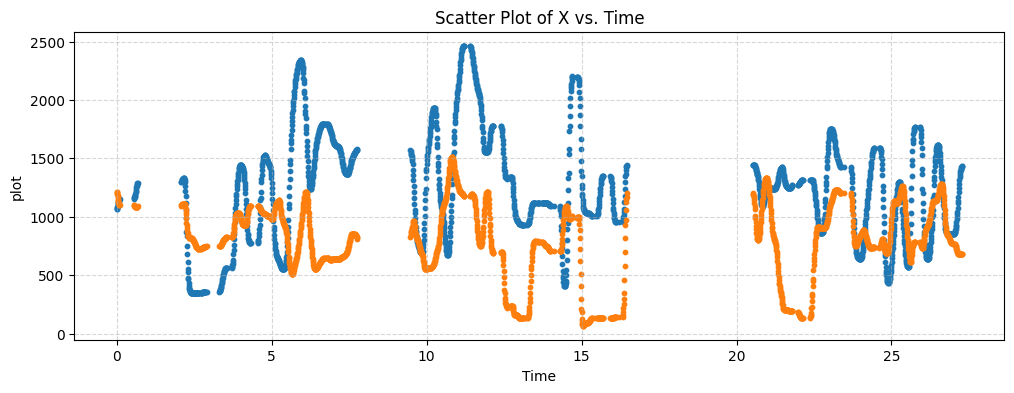

In [ ]:
actions_to_plot = actions[:len(actions)//2]
plot_actions_normal(actions_to_plot)

In [54]:
def fill_gaps(data, step=0.1):
    new_data = []
    for i in range(len(data) - 1):
        curr = data[i]
        nxt = data[i + 1]
        new_data.append(curr)
        dt = nxt["timestamp"] - curr["timestamp"]
        if dt > step:
            n_steps = int(dt // step)
            for j in range(1, n_steps + 1):
                t = curr["timestamp"] + j * step
                if t < nxt["timestamp"]:
                    ratio = (t - curr["timestamp"]) / dt
                    x = curr["x"] + ratio * (nxt["x"] - curr["x"])
                    y = curr["y"] + ratio * (nxt["y"] - curr["y"])
                    new_data.append({"timestamp": round(t, 10), "x": x, "y": y})
    new_data.append(data[-1])
    return new_data

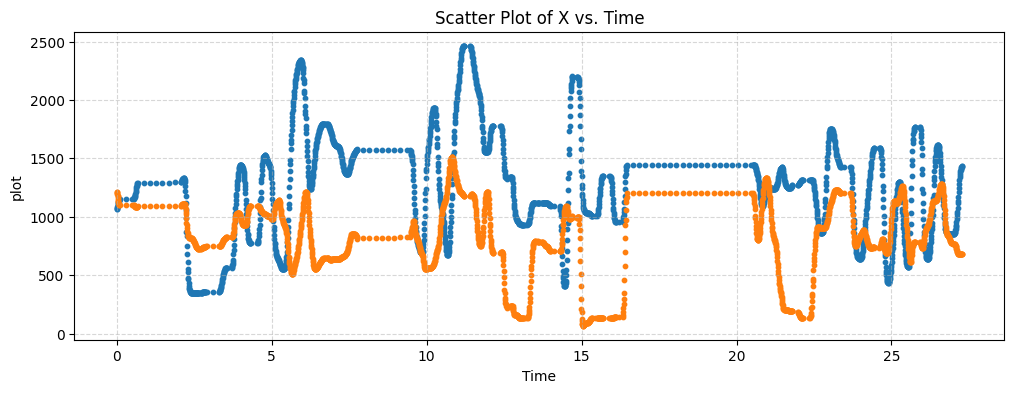

In [ ]:
filled_actions = fill_gaps(actions_to_plot, step=0.2)
plot_actions_normal(filled_actions)

In [ ]:
frame_timestamps = []

previous_time = None

container.seek(0, any_frame=True)  # Reset to the start of the video
for i, frame in enumerate(container.decode(video=0)):
    # Compute frame time
    pts = frame.pts
    one_frame_time = float(512 * video_stream.time_base)
    seconds = float(pts * video_stream.time_base) - one_frame_time
    if i % 15 == 0:
        frame_timestamps.append(seconds)

In [46]:
import numpy as np
frame_timestamps = np.array(frame_timestamps)
len(frame_timestamps)

61

In [67]:
frame_cutoff_lines = frame_timestamps 
frame_cutoff_lines_understandable = frame_timestamps - actions[0]['timestamp']

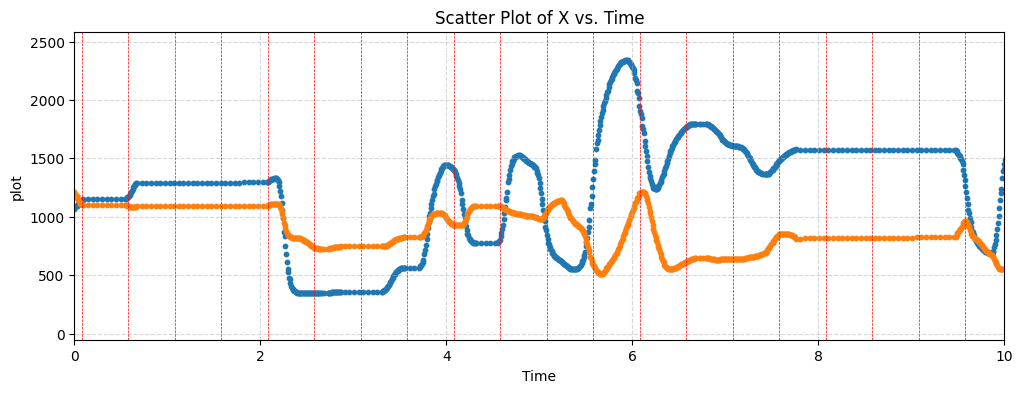

In [ ]:
filled_actions = fill_gaps(actions_to_plot, step=0.05)
plot_actions_normal(filled_actions, frame_cutoff_lines=frame_cutoff_lines_understandable, x_range=(0, 10))

In [69]:
def split_data_linear(data, splits):
    segments = []
    curr_segment = []
    split_idx = 0
    next_split = splits[split_idx] if split_idx < len(splits) else None

    for pt in data:
        # advance to the correct split segment
        while next_split is not None and pt['timestamp'] >= next_split:
            # close out the current segment
            segments.append(curr_segment)
            curr_segment = []
            split_idx += 1
            next_split = splits[split_idx] if split_idx < len(splits) else None

        curr_segment.append(pt)

    # final segment
    segments.append(curr_segment)
    return segments

In [72]:
frame_cutoff_lines[0]

np.float64(1749741013.8666668)

In [100]:
from matplotlib import cm

def plot_actions(segments, frame_cutoff_lines=None, x_range=None):
    if frame_cutoff_lines is None:
        frame_cutoff_lines = []

    # Split data into segments
    cmap = cm.get_cmap('tab10')
    
    # Prepare figure
    plt.figure(figsize=(12, 4))
    
    # Base time offset
    t0 = segments[0][0]['timestamp']
    
    # Plot each segment with a distinct color
    for i, seg in enumerate(segments):
        times = [(pt['timestamp'] - t0) for pt in seg]
        xs = [pt['x'] for pt in seg]
        ys = [pt['y'] for pt in seg]
        color = cmap(i % cmap.N)
        plt.scatter(times, xs, marker='o', s=10, color=color, label=f'Segment {i} X')
        plt.scatter(times, ys, marker='o', s=10, color=color, alpha=0.6, label=f'Segment {i} Y')
    
    # Plot cutoff lines
    for line in frame_cutoff_lines:
        plt.axvline(x=line, color='red', linestyle='--', linewidth=0.5)
    
    # Labels and title
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.title("Scatter Plot of X and Y vs. Time by Segment")
    
    # X-axis limits
    if x_range is not None:
        plt.xlim(x_range[0], x_range[1])
    
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

/var/folders/xf/r74_8mdx5g165twr3q69gmpw0000gn/T/ipykernel_2486/1389824424.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


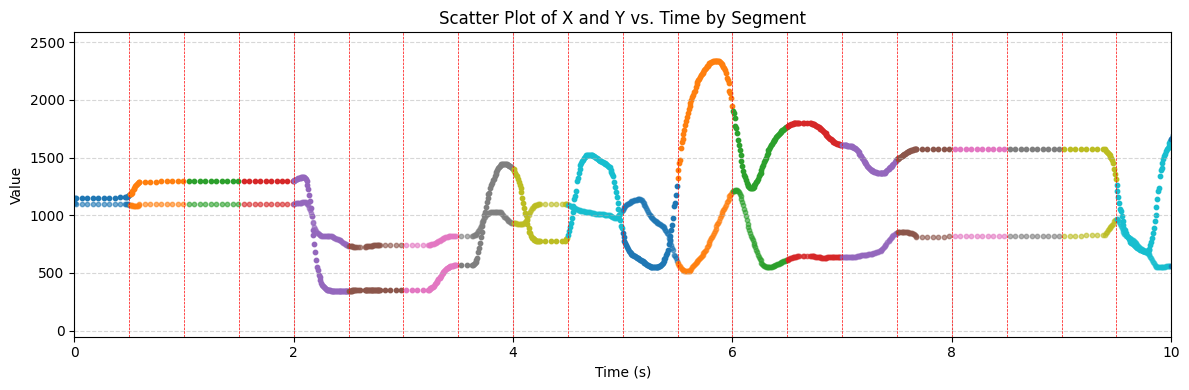

In [104]:
plot_actions(
    split_data_linear(filled_actions, frame_cutoff_lines)[1:],
    frame_cutoff_lines=frame_cutoff_lines_understandable[1:]-frame_cutoff_lines_understandable[0],
    x_range=(0, 10)
)

In [105]:
segments = split_data_linear(filled_actions, frame_cutoff_lines)[1:]

In [165]:
import numpy as np

def fit_quartic_endpoints(times, values):
    """
    Fit a quartic f(t)=a4*t^4 + a3*t^3 + a2*t^2 + a1*t + a0 through all data,
    enforcing f(t0)=x0 and f(tN)=xN, least-squares on interior points.
    """
    t0, tN = times[0], times[-1]
    T = tN - t0
    x0, xN = values[0], values[-1]

    # If segment too small, fallback to linear
    if len(times) <= 2 or T == 0:
        a0 = x0
        a1 = (xN - x0) / T if T != 0 else 0
        return np.array([0, 0, 0, a1, a0]), t0

    interior = [(times[i], values[i]) for i in range(1, len(times)-1)]
    A = []
    b = []
    for ti, xi in interior:
        tr = ti - t0
        # RHS after removing endpoint linear interpolation
        const = x0 + (xN - x0) * (tr / T)
        # Coeffs for a4, a3, a2
        A.append([tr**4 - T**3 * tr,
                  tr**3 - T**2 * tr,
                  tr**2 - T    * tr])
        b.append(xi - const)
    A = np.array(A)
    b = np.array(b)

    # Solve for [a4, a3, a2]
    sol, *_ = np.linalg.lstsq(A, b, rcond=None)
    a4, a3, a2 = sol

    # Compute a1 from endpoint constraint
    a0 = x0
    a1 = (xN - x0 - a4*T**4 - a3*T**3 - a2*T**2) / T
    return np.array([a4, a3, a2, a1, a0]), t0

def fit_cubic_endpoints(times, values):
    """
    Fit a cubic f(t)=a3 t^3 + a2 t^2 + a1 t + a0 through all data,
    enforcing f(t0)=x0 and f(tN)=xN, using least squares on interior points.
    """
    # Relative times
    t0, tN = times[0], times[-1]
    T = tN - t0
    x0, xN = values[0], values[-1]
    # If no interior points, just interpolate linearly
    if len(times) <= 2:
        a0 = x0
        a1 = (xN - x0) / T if T != 0 else 0
        return np.array([0, 0, a1, a0]), t0
    
    # Build reduced system for unknowns a3, a2
    interior = [(times[i], values[i]) for i in range(1, len(times)-1)]
    A = []
    b = []
    for ti, xi in interior:
        tr = ti - t0
        # Compute RHS constant term from endpoints
        const = (xN - x0) * (tr / T)
        # Coeffs for a3 and a2
        row = [
            tr**3 - (T**2 * tr),  # coefficient of a3
            tr**2 - (T   * tr)    # coefficient of a2
        ]
        A.append(row)
        b.append(xi - x0 - const)
    A = np.array(A)
    b = np.array(b)
    
    # Solve least squares for a3, a2
    sol, *_ = np.linalg.lstsq(A, b, rcond=None)
    a3, a2 = sol
    # Recover a1 and a0
    a0 = x0
    a1 = (xN - x0 - a3*T**3 - a2*T**2) / T
    return np.array([a3, a2, a1, a0]), t0

# Example for one segment:
# segment = segments[0]   # one of the lists you split
# times = np.array([pt['timestamp']-segment[0]["timestamp"] for pt in segment])
# xs    = np.array([pt['x']         for pt in segment])
# coefs, offset = fit_cubic(times, xs)
# print("Cubic for x(t):", coefs, "(shifted by t0 =", offset, ")")

In [166]:
def plot_segments_with_cubics(actions, splits, x_range=None):
    segments = split_data_linear(actions, splits)
    t0_global = actions[0]['timestamp']

    plt.figure(figsize=(12, 4))

    for seg in segments:
        if len(seg) < 2:
            continue  # skip too-small segments

        times = np.array([pt['timestamp'] for pt in seg])
        times_rel_global = times - t0_global
        x_vals = np.array([pt['x'] for pt in seg])

        # Scatter original data
        plt.scatter(times_rel_global, x_vals, s=5, marker='o', alpha=0.3)

        # Fit cubic
        coeffs, t0 = fit_quartic_endpoints(times, x_vals)
        # Build fine grid over this segment for plotting
        t_fit_rel = np.linspace(times[0] - t0, times[-1] - t0, 100)
        x_fit = np.polyval(coeffs, t_fit_rel)
        # Convert back to global-relative time
        t_fit_global = t_fit_rel + (t0 - t0_global)
        plt.plot(t_fit_global, x_fit, linewidth=1.5)

    # Optional split lines
    for line in splits:
        plt.axvline(x=line - t0_global, linestyle='--', linewidth=0.7)
    
    if x_range is not None:
        plt.xlim(x_range[0], x_range[1])

    plt.xlabel("Time (s)")
    plt.ylabel("X value")
    plt.title("Cubic Fits of Each Segment Overlaid on Data")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

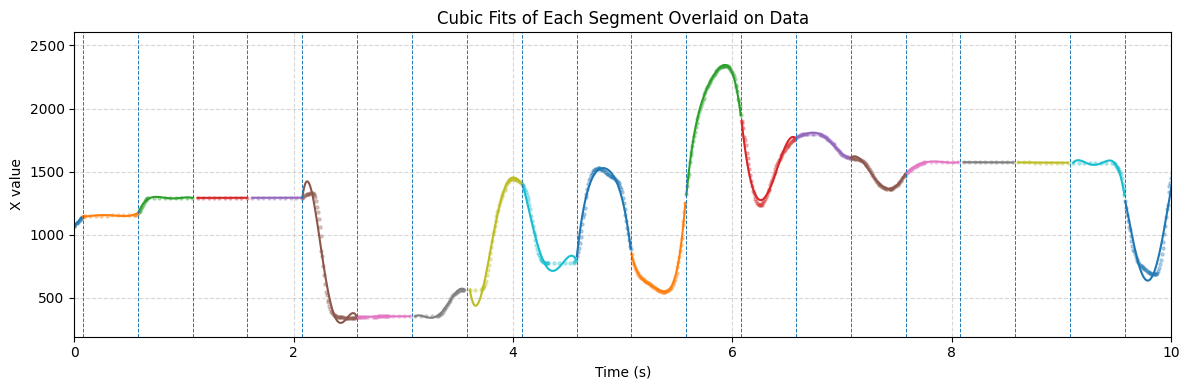

In [167]:
plot_segments_with_cubics(filled_actions, frame_cutoff_lines, x_range=(0, 10))

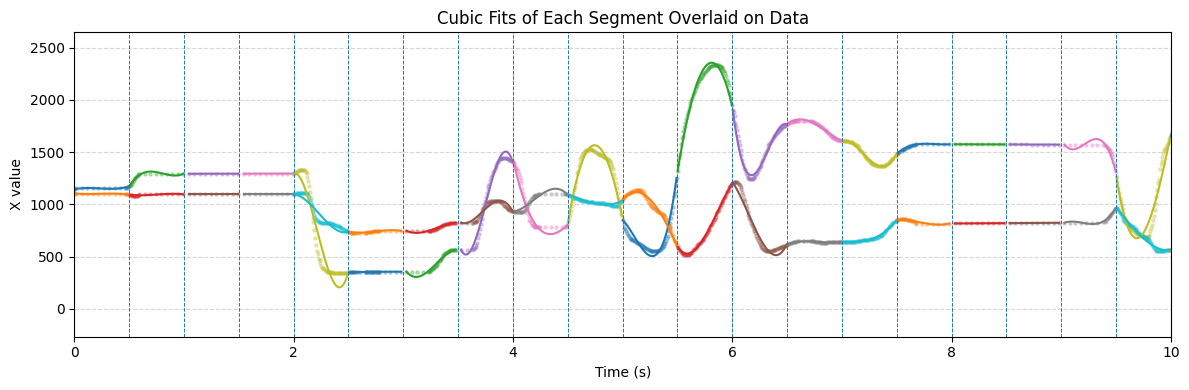

In [ ]:
actions = filled_actions
splits = frame_cutoff_lines
x_range = (0, 10)

segments = split_data_linear(actions, splits)[1:]
splits=splits[1:]
t0_global = segments[0][0]['timestamp']

plt.figure(figsize=(12, 4))

new_cubic_points = []
for seg in segments:
    if len(seg) < 2:
        continue  # skip too-small segments

    times = np.array([pt['timestamp'] for pt in seg])
    times_rel_global = times - t0_global

    x_vals = np.array([pt['x'] for pt in seg])
    y_vals = np.array([pt['y'] for pt in seg])

    # Scatter original data
    plt.scatter(times_rel_global, x_vals, s=5, marker='o', alpha=0.3)
    plt.scatter(times_rel_global, y_vals, s=5, marker='o', alpha=0.3)

    # Fit cubic
    coeffs, t0 = fit_cubic_endpoints(times, x_vals)
    # Build fine grid over this segment for plotting
    t_fit_rel = np.linspace(times[0] - t0, times[-1] - t0, 50)
    x_fit = np.polyval(coeffs, t_fit_rel)
    # Convert back to global-relative time
    t_fit_global = t_fit_rel + (t0 - t0_global)
    plt.plot(t_fit_global, x_fit, linewidth=1.5)

    # Fit cubic for y values
    coeffs_y, _ = fit_cubic_endpoints(times, y_vals)
    y_fit = np.polyval(coeffs_y, t_fit_rel)
    plt.plot(t_fit_global, y_fit, linewidth=1.5)

    for t, x, y in zip(t_fit_global, x_fit, y_fit):
        new_cubic_points.append({
            'timestamp': float(t + t0_global),
            'x': int(x),
            'y': int(y)
        })

# Optional split lines
for line in splits:
    plt.axvline(x=line - t0_global, linestyle='--', linewidth=0.7)

if x_range is not None:
    plt.xlim(x_range[0], x_range[1])

plt.xlabel("Time (s)")
plt.ylabel("X value")
plt.title("Cubic Fits of Each Segment Overlaid on Data")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
video_stream.average_rate / 15

Fraction(2, 1)

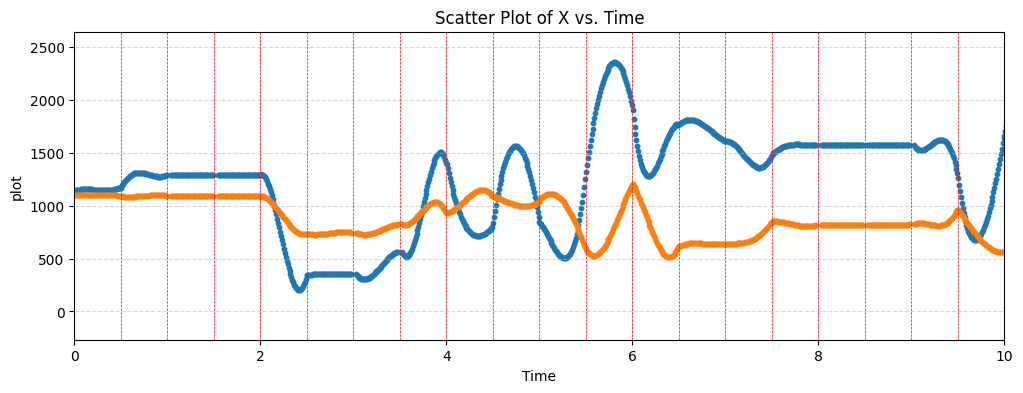

In [186]:
plot_actions_normal(new_cubic_points, frame_cutoff_lines=frame_cutoff_lines_understandable[1:]-frame_cutoff_lines_understandable[0], x_range=(0, 10))

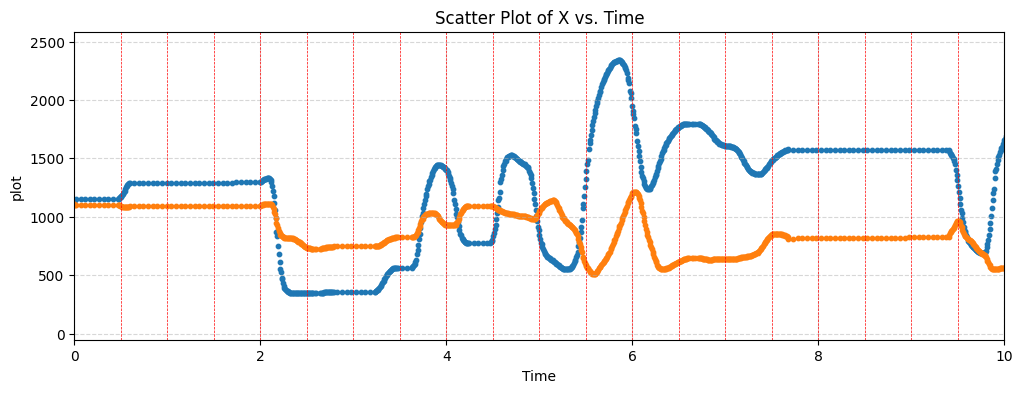

In [187]:
plot_actions_normal(filled_actions, frame_cutoff_lines=frame_cutoff_lines_understandable[1:]-frame_cutoff_lines_understandable[0], x_range=(0, 10))

In [216]:
from actioncollector.models import Action, MouseMove
import json

# actions = [Action.from_action_type(MouseMove(x=action["x"]//2, y=action["y"]//2), timestamp=action["timestamp"]) for action in new_cubic_points]
# actions = [Action.from_action_type(MouseMove(x=action["x"]//2, y=action["y"]//2), timestamp=action["timestamp"]) for action in new_cubic_points]
actions = [{**action} for action in new_cubic_points]
timestamps = [action['timestamp'] for action in actions]
# with open("output_actions.jsonl", "w") as f:
#     for action in actions:
#         f.write(json.dumps(action.model_dump()) + "\n")

output = av.open('output_cubic.mp4', mode='w')
out_stream = output.add_stream('libx264', rate=video_stream.average_rate)
out_stream.width = video_stream.width
out_stream.height = video_stream.height
out_stream.pix_fmt = 'yuv420p'

previous_time = None

container.seek(0, any_frame=True)  # Reset to the start of the video
for i, frame in enumerate(container.decode(video=0)):
    # Compute frame time
    if i >= 300:
        break

    # if i % 15 != 0:
    #     continue

    pts = frame.pts
    one_frame_time = float(512 * video_stream.time_base)
    # - -> red lags behind
    # 0 -> red is slightly ahead
    # + -> red is very ahead
    seconds = float(pts * video_stream.time_base) - one_frame_time  * 2

    # Find surrounding actions
    idx = bisect.bisect_left(timestamps, seconds)
    # low_idx = max(idx - 1, 0)
    # high_idx = min(idx, len(actions) - 1)

    # action_prev = actions[low_idx]
    # action_next = actions[high_idx]
    # action_prev_time = action_prev['timestamp']
    # action_next_time = action_next['timestamp']

    # print(f"Frame #{i}: PTS={pts:7d}  ({seconds:.3f} s); "
    #       f"Prev action at {action_prev_time:.3f}s, Next action at {action_next_time:.3f}s")

    # Linear interpolation (avoid division by zero)
    # if action_next_time != action_prev_time:
    #     t = (seconds - action_prev_time) / (action_next_time - action_prev_time)
    # else:
    #     t = 0.0
    # mid_x = action_prev['x'] + (action_next['x'] - action_prev['x']) * t
    # mid_y = action_prev['y'] + (action_next['y'] - action_prev['y']) * t
    mid_x = actions[idx]['x']
    mid_y = actions[idx]['y']
    print(mid_x, mid_y)
    # print(mid_x, mid_y)

    # Draw overlay on PIL image
    img = frame.to_image().convert('RGB')
    draw = ImageDraw.Draw(img)
    r = 20
    draw.ellipse((mid_x - r, mid_y - r, mid_x + r, mid_y + r), outline='red', width=3)

    # Convert back to VideoFrame
    annotated = av.VideoFrame.from_image(img)

    # Encode and mux
    for packet in out_stream.encode(annotated):
        output.mux(packet)

# Flush encoder
for packet in out_stream.encode():
    output.mux(packet)

output.close()
print("Finished writing output.mp4")


1144 1104
1144 1104
1150 1100
1154 1099
1155 1098
1155 1098
1155 1098
1153 1099
1152 1100
1150 1101
1148 1101
1148 1102
1149 1101
1152 1100
1156 1098
1163 1095
1180 1090
1223 1087
1257 1086
1288 1086
1303 1086
1310 1088
1313 1090
1310 1092
1302 1095
1294 1096
1287 1098
1279 1099
1275 1100
1276 1099
1284 1097
1292 1096
1292 1096
1292 1096
1292 1096
1292 1096
1292 1096
1292 1096
1292 1096
1292 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1293 1096
1294 1096
1280 1086
1232 1070
1158 1047
1029 1010
917 978
796 944
674 909
517 862
411 829
322 799
237 765
207 746
211 734
256 730
348 734
349 730
350 727
351 727
352 729
352 731
353 734
353 738
354 742
354 746
354 748
354 751
354 751
354 750
354 747
354 746
344 742
315 731
306 727
307 727
317 730
339 738
370 748
396 758
434 771
472 785
498 795
529 808
553 817
563 822
566 824
547 820
519 

In [ ]:
1749611989.699
1749611989.388258
1749611989.699
1749611989.388258
1749611989388.258

1749611989566.0156

In [32]:
(26874040162294-26874040161782)*video_stream.time_base

Fraction(1, 30)

In [14]:
container.duration

10166667